In [1]:
import numpy as np
from torchvision import models, transforms
from PIL import Image
from torchvision import datasets
from torchvision.transforms import ToTensor
# from captum.attr import Saliency
# from captum.attr import visualization as vis
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [10]:
# Prepare input.
# Code here is adapted or based on  https://avandekleut.github.io/vae/
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# train_loader = torch.utils.data.DataLoader(training_data, batch_size=256, shuffle=True)


In [3]:
class UnFlatten(nn.Module):
	def forward(self, data):
		"""
		Unflattens the network at the beginning of the decoder
		@param data: data to be unflattened
		@return: unflattened data
		"""
		return data.view(data.size(0), -1, 1, 1)


# code adapted form https://avandekleut.github.io/vae/
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))



In [4]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [5]:
from torch.utils.tensorboard import SummaryWriter
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    writer = SummaryWriter("runs/fashion_trainer")

    running_loss = 0
    for epoch in range(epochs):
        print(epoch)
        for i, (x, y) in tqdm(enumerate(data)):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            writer.add_scalars('Training vs. Validation Loss',
                           {'Training': loss},
                           epoch+ 1)
            tb_x = epoch * len(data) + i + 1

            writer.add_scalar('Loss/train', loss , tb_x)

            running_loss += loss.item()
            loss.backward()
            opt.step()
        print("average_loss:", running_loss/len(data))
        writer.flush()
        running_loss = 0 
    return autoencoder


In [51]:
latent_dims = 4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device= 'cuda'
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
# data = torch.utils.data.DataLoader(
#         torchvision.datasets.MNIST('./data',
#                transform=torchvision.transforms.ToTensor(),
#                download=True),
#         batch_size=128,
#         shuffle=True)

autoencoder = train(vae, training_data)


0


60000it [10:50, 92.21it/s] 


average_loss: 30.404325474770864
1


60000it [13:12, 75.69it/s] 


average_loss: 28.509612897777558
2


60000it [13:07, 76.17it/s] 


average_loss: 28.272327308988572
3


60000it [11:08, 89.74it/s] 


average_loss: 28.179287383540473
4


60000it [10:33, 94.70it/s] 


average_loss: 28.108763921689988
5


60000it [09:52, 101.21it/s]


average_loss: 28.061394771130878
6


60000it [11:21, 87.98it/s] 


average_loss: 28.02148072444598
7


60000it [11:27, 87.25it/s] 


average_loss: 27.98142943124771
8


60000it [10:18, 97.06it/s] 


average_loss: 27.98896668162346
9


60000it [09:06, 109.87it/s]

average_loss: 27.95169724197388


In [52]:
latent_space = []
for x, y in training_data:
  vae.train(False)
  output = vae.encoder(x.to(device))
  latent_space.append((output,y))

In [53]:
!pip install pandas

In [54]:
import pandas as pd
latent_x = [x.detach().cpu() for x, y in latent_space] 
latent_y = [y for x, y in latent_space] 
# df = pd.DataFrame(X)

In [55]:
x = np.concatenate(latent_x)
df = pd.DataFrame(x,columns =['A', 'B', 'C','D'])
# latent_x

In [56]:
df['y'] = latent_y

In [57]:
df

,A,B,C,D,y
0,-1.151902,-0.652092,-0.563561,0.569432,9
1,-0.123247,1.030863,1.314150,0.724584,0
2,0.782206,0.676229,-0.013003,0.077967,0
3,0.501339,0.001882,0.480673,0.393263,3
4,0.438046,-0.152142,1.326762,0.236725,0
...,...,...,...,...,...
59995,0.766936,0.343814,-0.777548,0.878663,5
59996,2.091086,0.144400,0.538652,1.092882,1
59997,0.645451,-0.152630,1.200903,-0.976525,3
59998,0.553601,0.209665,-0.089910,0.344291,0


In [58]:
from sklearn.manifold import TSNE
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df[['A', 'B', 'C','D']])

C:\Users\Harsha\anaconda3\envs\muse2022\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Harsha\anaconda3\envs\muse2022\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.070s...
[t-SNE] Computed neighbors for 60000 samples in 3.127s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

In [23]:
!pip install seaborn

  Using cached seaborn-0.12.0-py3-none-any.whl (285 kB)


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

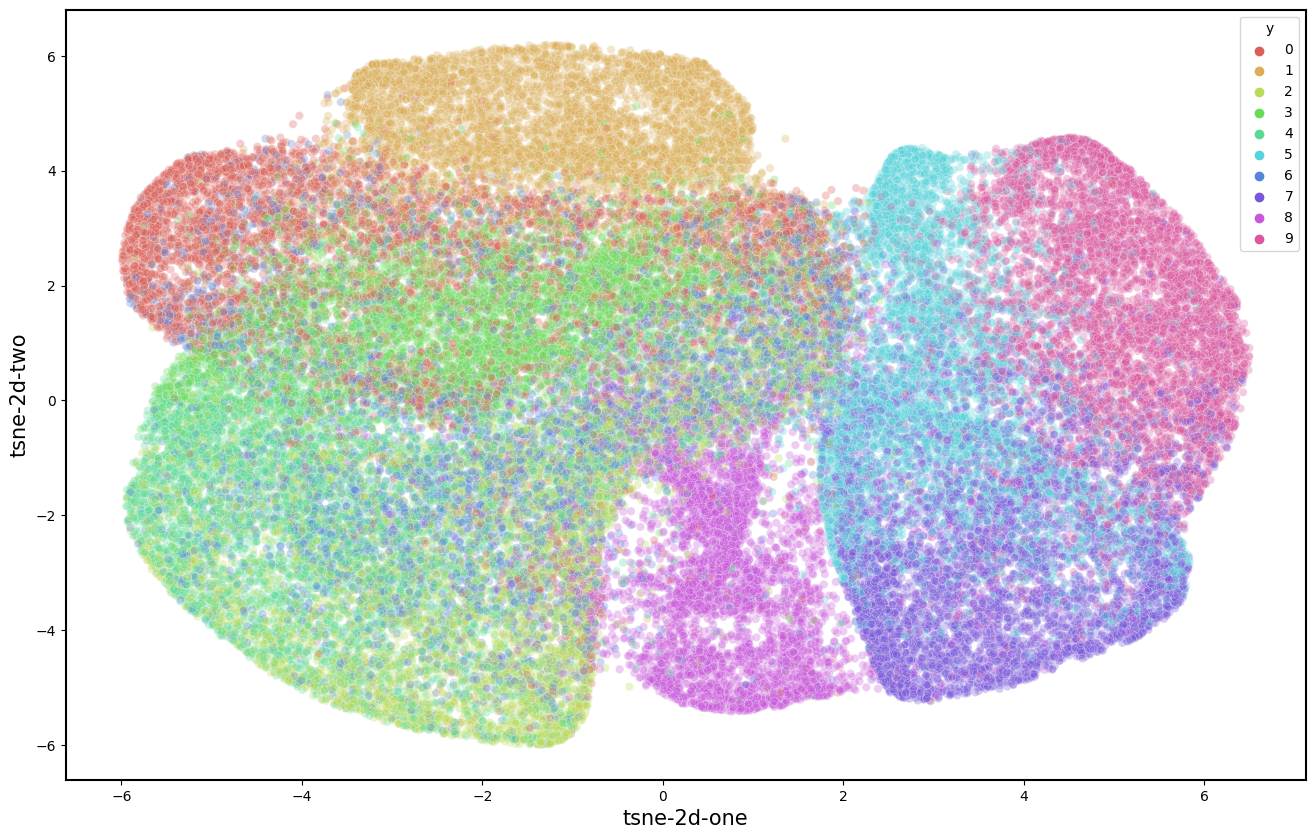

In [59]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

In [64]:
def plot_reconstructed(autoencoder, r0=(-5, 5), r1=(-5, 5), n=5):
    w = 28
    cells =  []
    for input_x in x[:25]:
        z = torch.Tensor(input_x).to(device)
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
        cells.append(x_hat)
#         plt.imshow(x_hat)
#         plt.show()
    g = isns.ImageGrid(cells, col_wrap=5, cbar=False)
    plt.show()

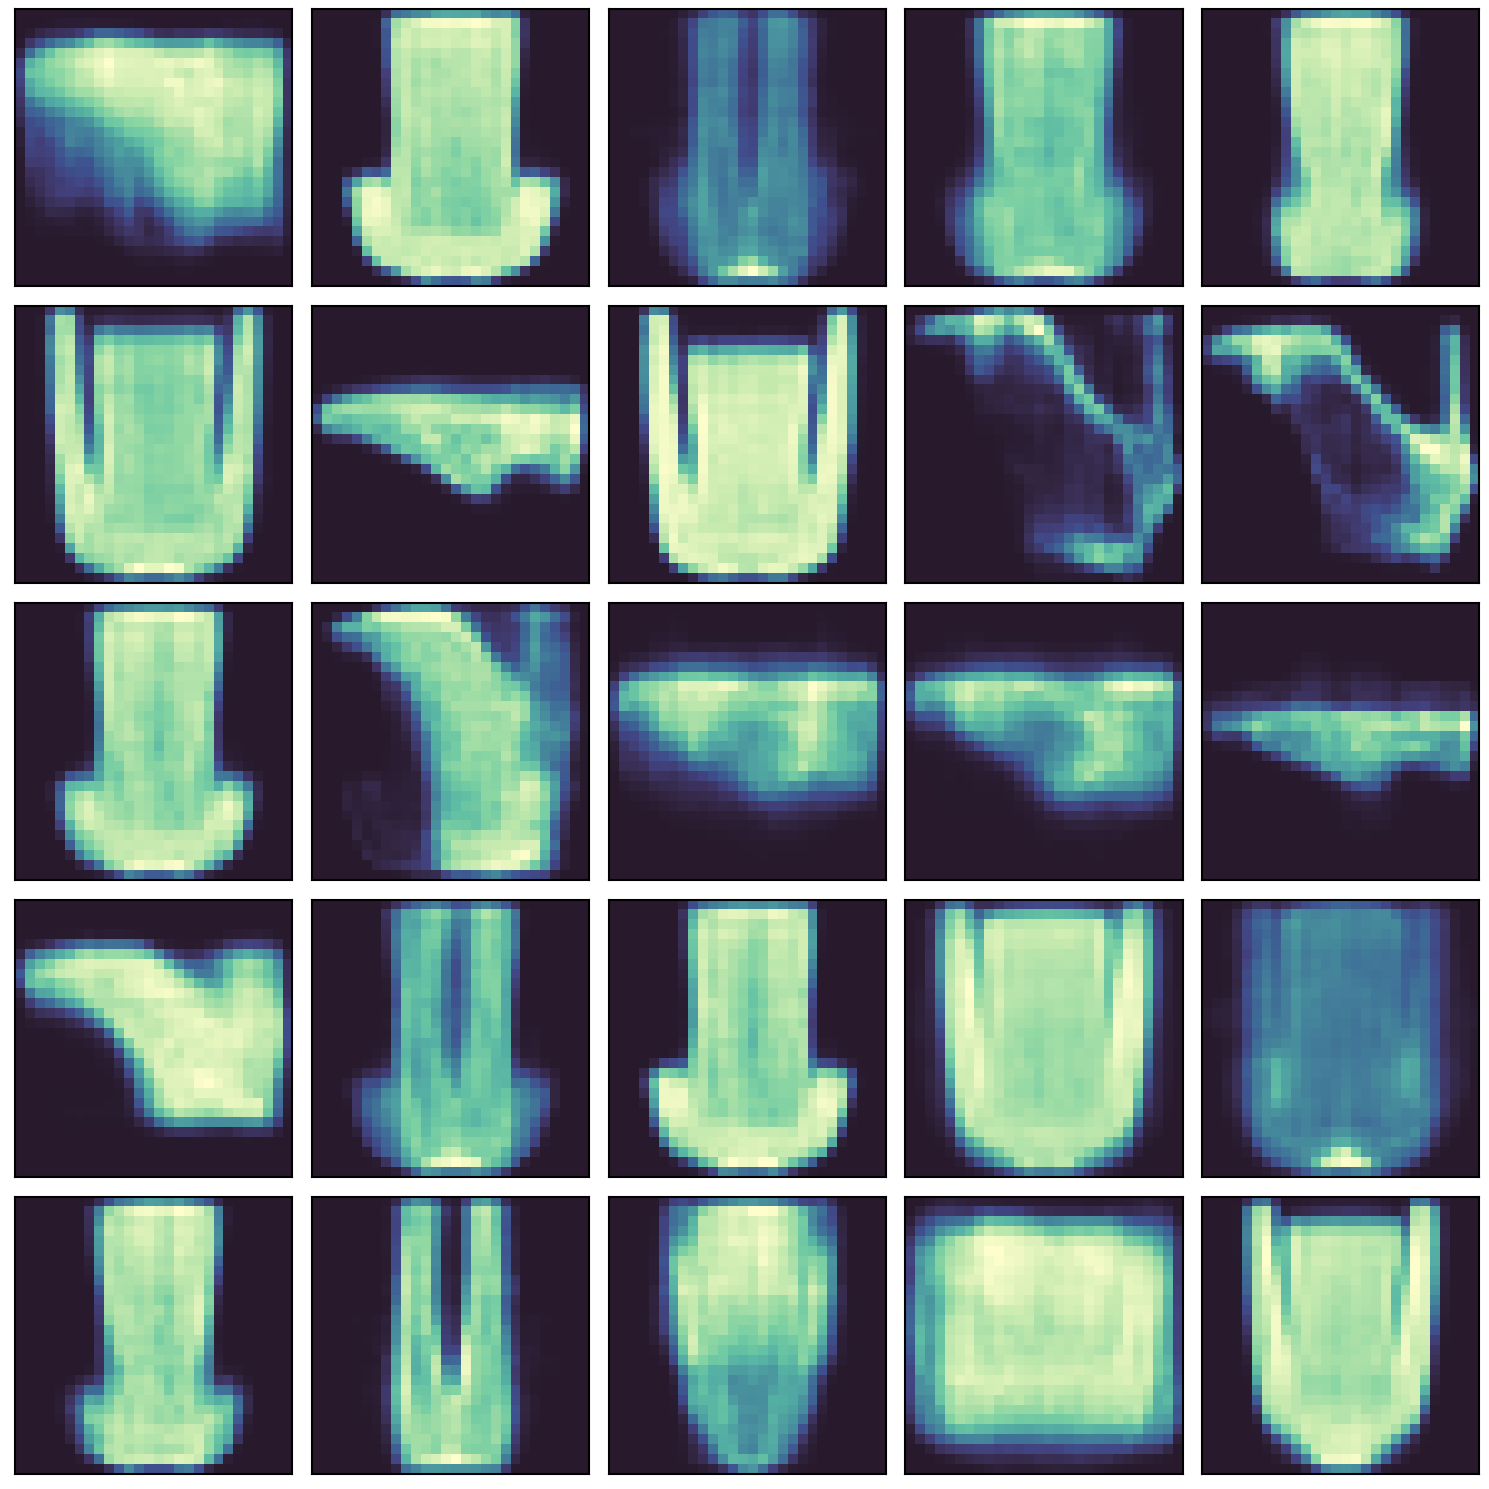

In [65]:
import seaborn_image as isns
plot_reconstructed(autoencoder)

In [79]:
def plot_reconstructed_dummy(autoencoder, r0=(-5, 5), r1=(-5, 5), n=5):
    w = 28
    cells =  []
    shift = np.linspace(-1,1,20)
    for i in shift:
        z = torch.Tensor(x[0]+np.array([0,i,0,0])).to(device)
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
        cells.append(x_hat)
#         plt.imshow(x_hat)
#         plt.show()
    g = isns.ImageGrid(cells, col_wrap=5, cbar=False)
    plt.show()

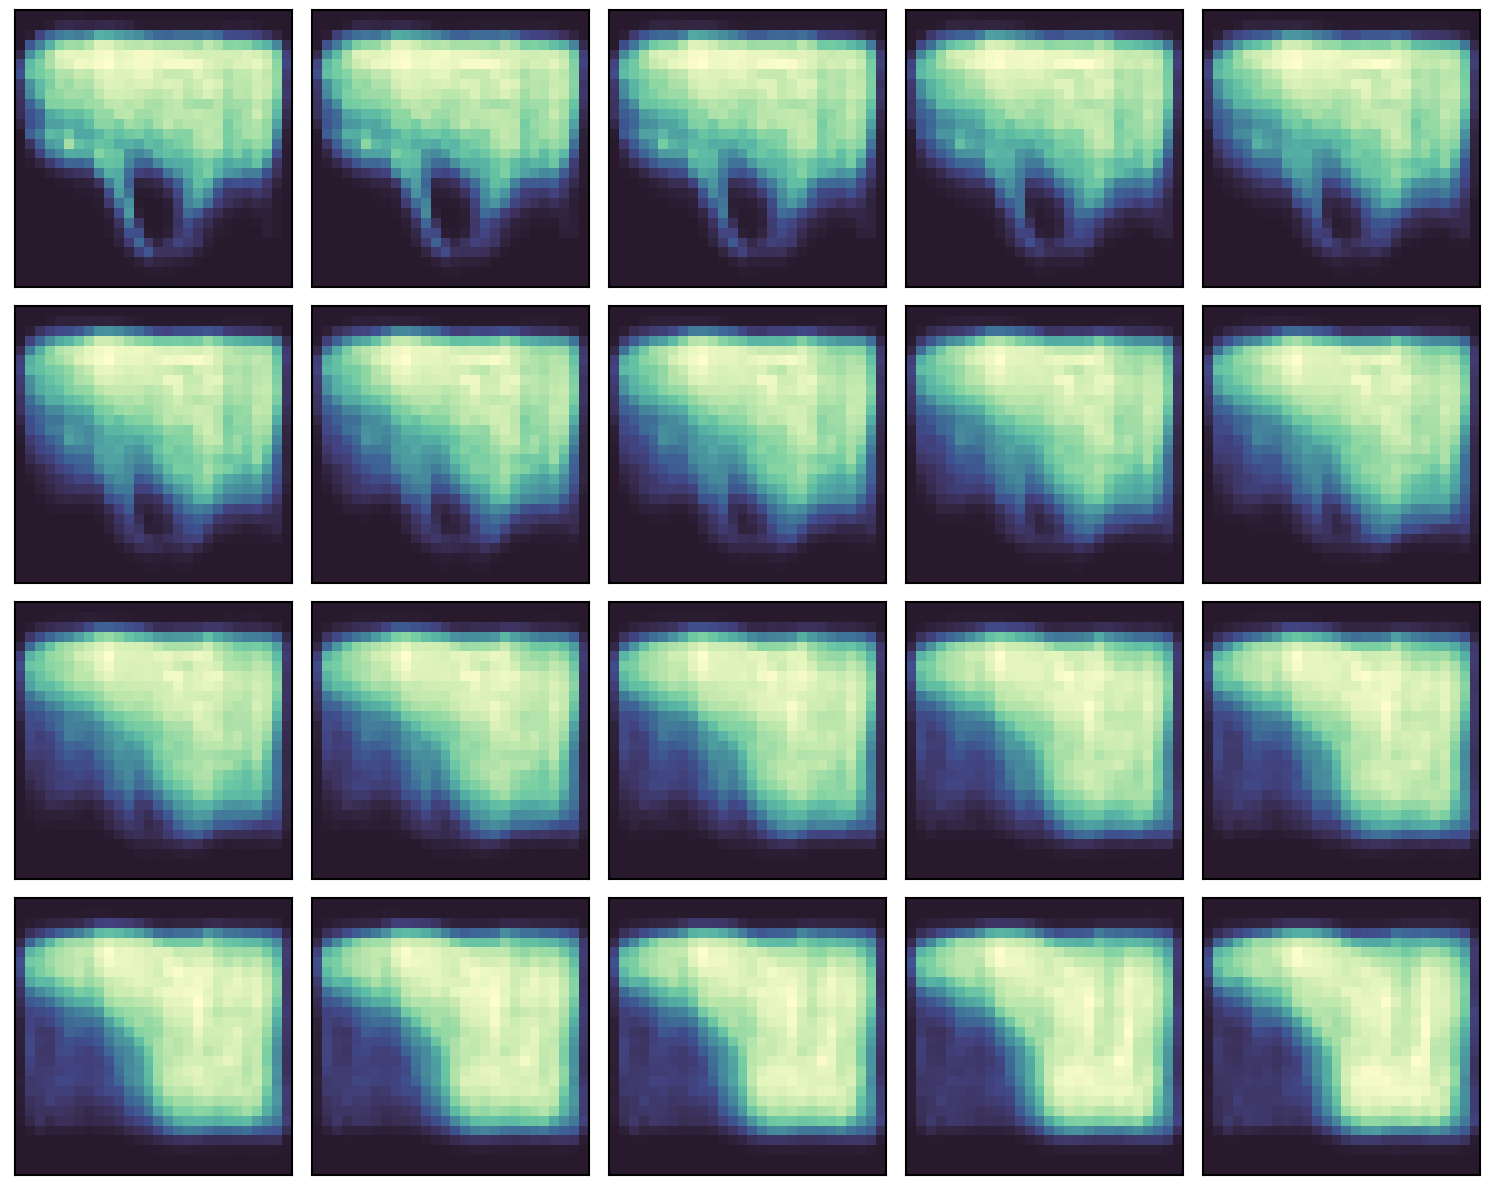

In [80]:
plot_reconstructed_dummy(autoencoder)